In [1]:
import pycomod as pcm
import numpy as np

In [2]:
class simple2(pcm.Model):
    def build(self):
        
        P1 = self.pool(5)
        P2 = self.pool(5)
        
        a_v = self.parameter([0.001, 0.005, 0.02])
        a_t = self.parameter([0, 100, 200])
        
        a = self.step(a_v, a_t)
        
        b = self.impulse([2, 4, 6], [10, 20, 30])
        
        #F1 = self.flow(lambda: 0.02*P1, src=P1)
        #F2 = self.flow(lambda: 0.02*P2, src=P2, discrete=True)
        
        @self.flow(src=P1)
        def F1():
            return 0.02*P1
        
        @self.flow(src=P2, discrete=True)
        def F2():
            return 0.02*P2
        
        
        #N = self.equation(lambda: P1 + P2)
        
        @self.equation
        def N():
            return P1 + P2
        
        #F3 = self.flow(lambda: b, src=P1, dest=P2)
        
        self.set_available(locals(), output=(P1, P2, N))
        
m2 = simple2()

In [ ]:
m2.write_excel_init()

In [3]:
mgr = pcm.RunManager()
mgr.run(m2, duration=400, label='My run')
#mgr.run(m, init="init.xlsx", dt=1, tunit=np.timedelta64(1, 'D'), label='My run')


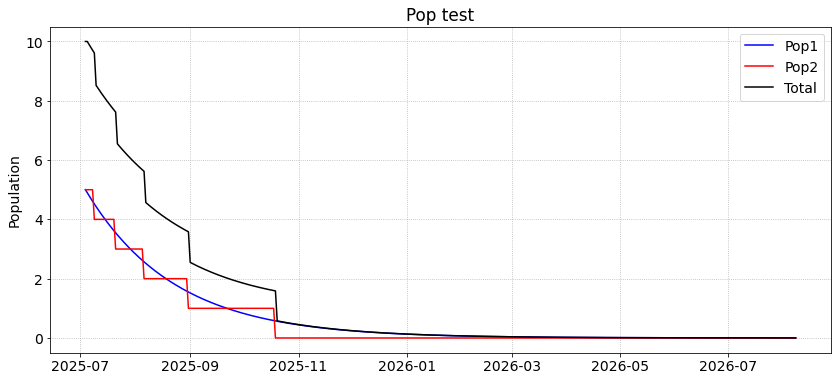

In [4]:
plt = pcm.Plotter(title='Pop test', ylabel='Population', fontsize=14)
plt.plot(mgr['My run'], 'P1', color='blue', label='Pop1')
plt.plot(mgr['My run'], 'P2', color='red', label='Pop2')
plt.plot(mgr['My run'], 'N', color='black', label='Total')

In [ ]:
class bigmodel(pcm.Model):
    def build(self):
        m1 = self.submodel(simple2())
        m2 = self.submodel(simple2())
        
        self.set_available(locals(), output=(m1,m2))
        
m3 = bigmodel()

In [ ]:
m3.write_excel_init()

In [ ]:
mgr = pcm.RunManager()
mgr.run(m3, duration=400, label='My run')
#mgr.run(m3, init="init.xlsx", dt=1, tunit=np.timedelta64(1, 'D'), label='My run')


In [ ]:
plt = pcm.Plotter(title='Pop test', ylabel='Population', fontsize=14)
plt.plot(mgr['My run'], 'm1.P1', color='blue', label='Pop1')
plt.plot(mgr['My run'], 'm1.P2', color='black', label='Pop2')

In [ ]:
class RoutineModel(pcm.Model):
    def build(self):
        
        P = self.pool(50) # population pool
        C = self.pool(0) # course pool
        F = self.pool(0) # course failures
        
        a = self.parameter(0.002) # attrition rate
        
        @self.flow(src=P, discrete=True)
        def attr():
            return a*P

        @self.process
        def sub_course(n):
            C.remove(n)
            
            yield pcm.Delay(5)
            
            C.add(n)
            
            return round(n*0.5)
        
        
        @self.process
        def on_course(n):
            C.add(n)
            
            yield pcm.Delay(5)
            
            s = yield sub_course(2)
            f = 2-s
            
            C.remove(f)
            F.add(f)
            
            yield pcm.Delay(5)
            
            C.remove(n - f)
            
            return round((n-f)*0.8 - f)

        
        @self.process(time=30, args=(15,))
        def load_course(n):
            P.remove(n)
            
            s = yield on_course(n)
            
            P.add(s)
            F.add(n-s)
    
            
        @self.process(time=0)
        def extra():
            
            while True:
                P.remove(5)
                yield pcm.Delay(2)
                P.add(5)
                yield pcm.Delay(15)
            

        @self.process(time=50)
        def update_attr():
            a.set(0.008)
        
               
        self.set_available(locals(), output=(P, C, F, a))
        
m4 = RoutineModel()
        

In [ ]:
mgr = pcm.RunManager()
mgr.run(m4, duration=100, label='My run')

In [ ]:
plt = pcm.Plotter(title='Pop test', ylabel='Population', fontsize=14)
plt.plot(mgr['My run'], 'P', color='blue', label='Pop', step=True)
plt.plot(mgr['My run'], 'C', color='black', label='Course', step=True)
plt.plot(mgr['My run'], 'F', color='red', label='Fails', step=True)

In [ ]:
plt = pcm.Plotter(title='Attrition rate', ylabel='Rate', fontsize=14)
plt.plot(mgr['My run'], 'a', color='orange', label='Attrition rate', step=True)

In [ ]:
class Course(pcm.Model):
    def build(self, minLoad=12, maxLoad=18, startTime=30, startInt=60, duration = 40, passRate=0.8):
        W = self.pool(0, name='W') # waitlist
        C = self.pool(0, name='C') # on course
        P = self.pool(0, name='P') # pass
        F = self.pool(0, name='F') # fail
        
        @self.process(time=0)
        def enter():
            while True:
                W.add(8)
                yield pcm.Delay(31)
                
        @self.process
        def attend_serial(n):
            W.remove(n)
            C.add(n)
            yield pcm.Delay(duration)
            C.remove(n)
            
            np = round(n*passRate)
            
            P.add(np)
            F.add(n - np)
            
                
        @self.process(time=startTime)
        def start():
            while True:
                if W >= minLoad:
                    n = min(int(W), maxLoad)
                    self.start_process(attend_serial(n))
                    
                yield pcm.Delay(startInt)                     
            
m5 = Course()
        

In [ ]:
mgr = pcm.RunManager()
mgr.run(m5, duration=365*1, label='My run')

In [ ]:
plt = pcm.Plotter(title='Course test', ylabel='Population', fontsize=14)
plt.plot(mgr['My run'], 'W', color='grey', label='Wait', step=True)
plt.plot(mgr['My run'], 'C', color='blue', label='On Course', step=True)
plt.plot(mgr['My run'], 'P', color='green', label='Pass', step=True)
plt.plot(mgr['My run'], 'F', color='red', label='Fail', step=True)

In [ ]:
# IDEAS:
# - make time proper DES time, not time steps (though any actions on the time step will add values on the time step)
# - make time an object owned by the head model, like the event queue, and not a building block, just a value held by the object
# - building block should store the values and times, not just a series of values on the fixed time step
# - update plotting to use DES time

# - make process and events aware of the event_queue and sim_time so they can run themselves or schedule themselves

# - flag outputs by adding a "name" parameter to element constructors
#   - this avoid the set_available call
# - add an optional 'key' parameter, if present "name" becomes a dictionary and "key" accesses the item
# - this allows the user to store multiple elements with the same name in a collection
# - this change is also affects the _out list, which is problematic


# - allow the event returned by calling a process to be run


# - fix equations to not have a value input (did it so the initial value could be specified at the start of the model)
# - but this means this might have to be an input, which doesn't make sense for an equation
# - solution should be to reset equations last so they can reference other values as needed
# - DONE


In [ ]:
rng = np.random.default_rng()

class SIR(pcm.Model):
    def build(self):
        S = self.pool(100, name='S')
        I = self.pool(0, name='I')
        R = self.pool(0, name='R')
        
        N = self.equation(lambda: S+I+R, name='N')
        
        b = self.parameter(0.2)
        g = self.parameter(0.1)
        
        Fsi = self.flow(lambda: b*S*I/N, src=S, dest=I)
        Fir = self.flow(lambda: g*I, src=I, dest=R)
        
        @self.process(time=0)
        def Fi():
            n = rng.binomial(S, 0.1)
            S.remove(n)
            I.add(n)
            
            b.set(rng.normal(0.2, 0.05))
        
m = SIR()
        

In [ ]:
mgr = pcm.RunManager()
mgr.run_mc(m, duration=100, reps=100, label='My run')

In [ ]:
plt = pcm.Plotter(title='Pop', ylabel='Population', fontsize=14)
plt.plot_mc(mgr['My run'], 'S', color='green', label='S', step=False)
plt.plot_mc(mgr['My run'], 'I', color='red', label='I', step=False)
plt.plot_mc(mgr['My run'], 'R', color='blue', label='R', step=False)
plt.plot_mc(mgr['My run'], 'N', color='orange', label='N', step=False)